## Xマッチからブキ偏差値を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 4, 1)
date_to = dt.date(2023, 5, 13)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 50852


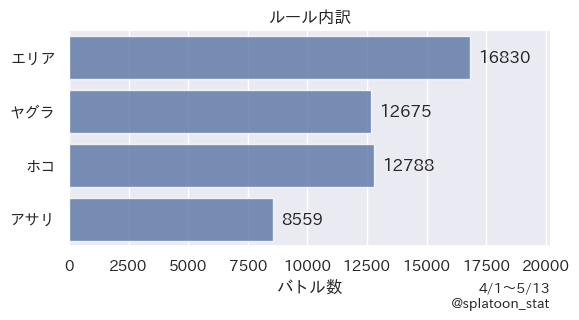

パワー不明バトル数: 2285


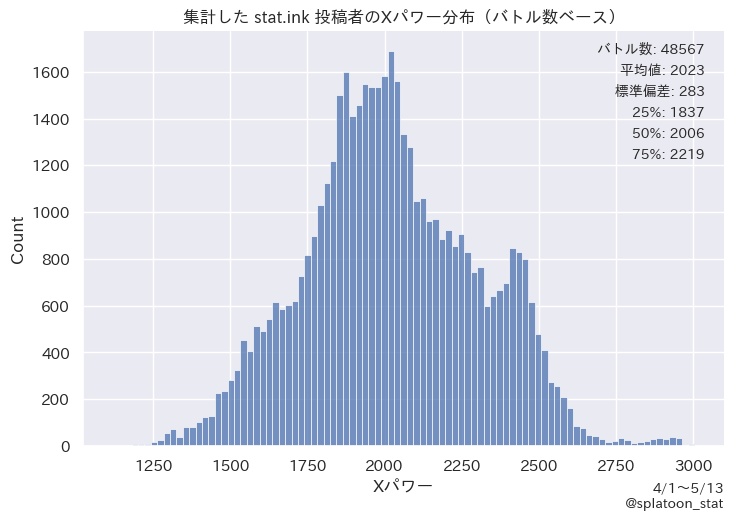

In [2]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [4]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

usage        power  usage-bc   usage-z   power-z  \
mode   weapon                                                                  
area   sharp_neo         0.059638  2087.996781 -2.478909  2.033670  0.699207   
       sshooter_collabo  0.052381  1957.063706 -2.578034  1.891148 -1.049906   
       screwslosher      0.050624  2171.120631 -2.603901  1.853958  1.809644   
       liter4k           0.042280  2083.943707 -2.739087  1.659587  0.645062   
       wakaba            0.035413  1974.032508 -2.869915  1.471484 -0.823222   
...                           ...          ...       ...       ...       ...   
yagura rpen_5h           0.001544  2088.781061 -4.416230 -1.467448  1.674333   
       promodeler_mg     0.001465  1864.701667 -4.439239 -1.508075 -1.958948   
       96gal             0.001105  2001.458696 -4.560604 -1.722378  0.258466   
       carbon            0.000924  1920.480000 -4.634956 -1.853668 -1.054544   
       l3reelgun         0.000349  2045.809677 -5.012397 -2.520140  0.977584   

                         strength  strength-z  strength-t  
mode   weapon                                              
area   sharp_neo         2.000514    1.973841   69.738411  
       sshooter_collabo  0.756181    0.746099   57.460990  
       screwslosher      2.585030    2.550564   75.505643  
       liter4k           1.680894    1.658483   66.584833  
       wakaba            0.584285    0.576495   55.764946  
...                           ...         ...         ...  
yagura rpen_5h          -0.028464   -0.028084   49.719158  
       promodeler_mg    -2.418984   -2.386733   26.132674  
       96gal            -1.141846   -1.126622   38.733778  
       carbon           -2.094411   -2.066487   29.335131  
       l3reelgun        -1.281439   -1.264354   37.356457  

[316 rows x 8 columns]

### 可視化する

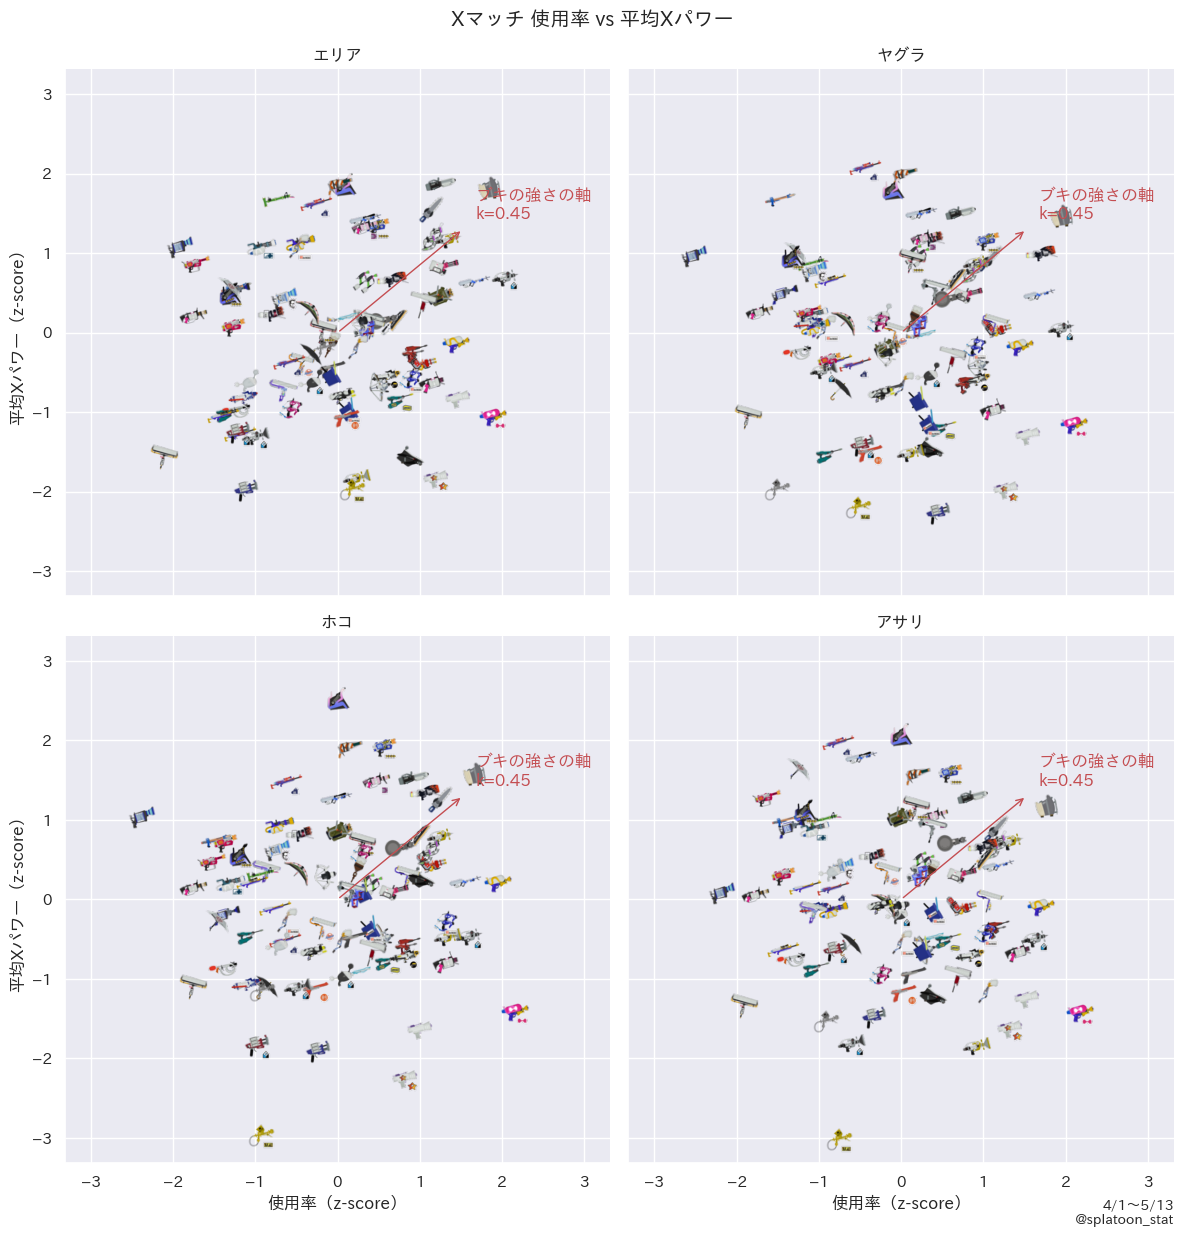

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

In [6]:
strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
strength_map["mean"] = strength_map.mean(axis=1)
strength_map = strength_map.sort_values("mean", ascending=False)
strength_map


mode,area,yagura,hoko,asari,mean
weapon,,,,,
screwslosher,75.505643,74.082371,72.621592,70.780626,73.247558
kugelschreiber,71.527616,65.139753,66.830850,64.780573,67.069698
jimuwiper,68.453471,64.120791,67.344773,64.412818,66.082963
sharp,67.672794,62.487734,64.501785,64.640337,64.825662
rapid_deco,62.160839,65.316004,66.569938,64.642379,64.672290
...,...,...,...,...,...
soytuber,34.552297,38.923155,34.034291,35.061303,35.642761
clashblaster,28.964004,38.785546,35.968366,37.961082,35.419750
clashblaster_neo,32.834269,37.283684,30.872293,39.889286,35.219883


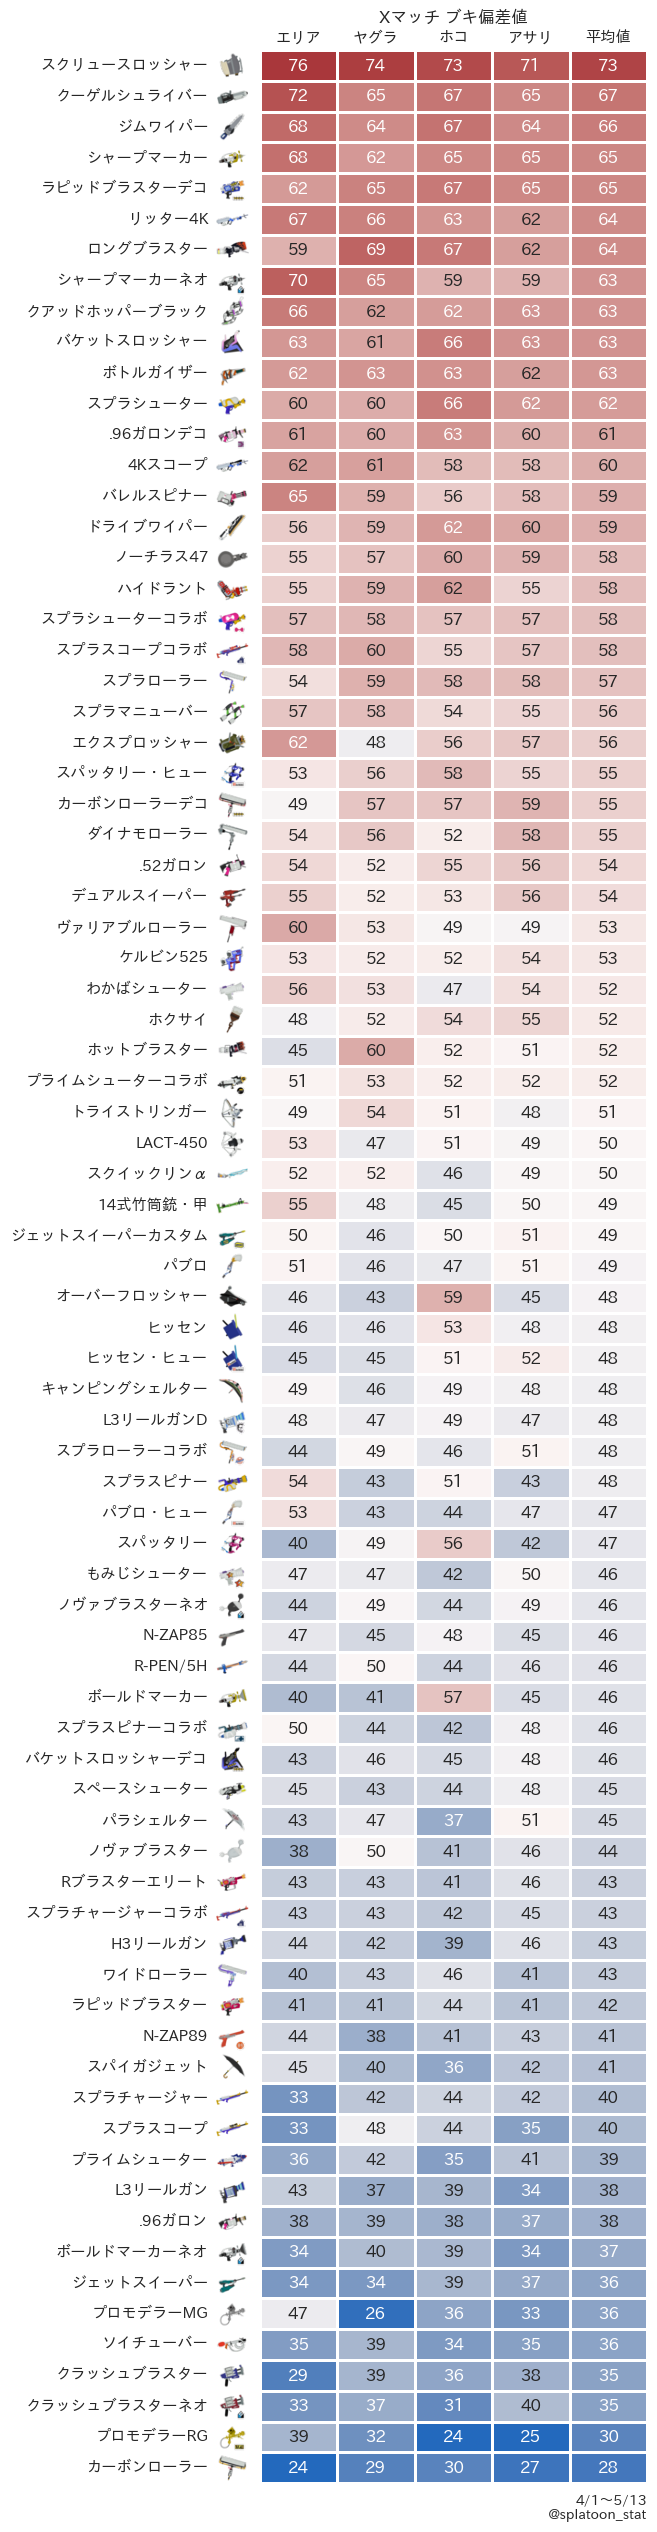

In [7]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

fig, ax = plt.subplots(figsize=(5, len(strength_map.index) * 0.4))
sns.heatmap(
    strength_map,
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_data_duration(battles), .3)

plt.show()